# RV Coefficient

In [142]:
import sys
sys.path.append("../../")

import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
from jax.config import config
config.update("jax_enable_x64", False)


# dependence measures
from jaxkern.similarity.rv import rv_coeff, rv_coeff_feat, pearson_corr_coeff, sub_pearson_corr_coeff
from jaxkern.kernels.linear import linear_kernel
from jaxkern.kernels.stationary import rbf_kernel
from jaxkern.kernels.utils import kernel_matrix
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.kernels.approx import RBFSampler
from jaxkern.kernels.sigma import estimate_sigma_median

from sklearn.preprocessing import StandardScaler

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [180]:
onp.random.seed(123)

# define samples
n_samples = 100
d_dimensions = 1

mu = 0.5
sigma = 25

# X Variable
X = mu + sigma * onp.random.randn(n_samples, d_dimensions)

# random rotation matrix
A = onp.random.rand(d_dimensions, d_dimensions)

# noise
eps = 2 * onp.random.randn(n_samples, d_dimensions)

# Y Variable
Y = X @ A
Y += eps

# 
X, Y = np.array(X), np.array(Y)

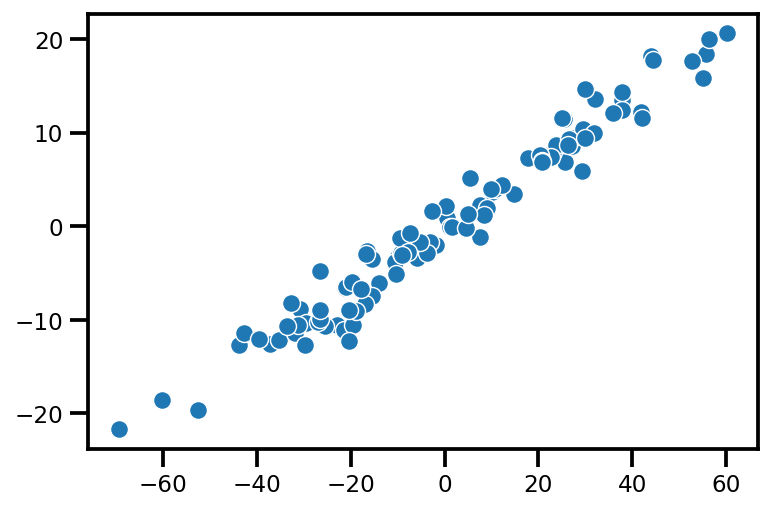

In [181]:
# visualize the distribution

plt.figure()

sns.scatterplot(x=X.squeeze(), y=Y.squeeze())
# sns.jointplot(x=X, y=Y,  kind="kde");

plt.show()

## Correlation Coefficient

$$
r = \frac{\sum (x - m_x) (y - m_y)}
             {\sqrt{\sum (x - m_x)^2 \sum (y - m_y)^2}}
$$

In [182]:
rho = pearson_corr_coeff(X.squeeze(), Y.squeeze())

print(rho)

0.9811311


## RV Coefficient

### Sample Space

In [183]:
rv_ = rv_coeff(X, Y)
rv_

DeviceArray(0.9626717, dtype=float32)

### Feature Space

In [184]:
rv_f = rv_coeff_feat(X, Y)
rv_f

DeviceArray(0.9626719, dtype=float32)

### Multivariate Data

In [193]:
# X Variable
d_dimensions = 2
X = mu + sigma * onp.random.randn(n_samples, d_dimensions)

# random rotation matrix
A = onp.random.rand(d_dimensions, d_dimensions)

# noise
eps = 2 * onp.random.randn(n_samples, d_dimensions)

# Y Variable
Y = X @ A
Y += eps

# 
X, Y = np.array(X), np.array(Y)
X.shape, Y.shape

((1000, 2), (1000, 2))

### Feature Space

In [194]:
rv_f = rv_coeff_feat(X, Y, center=False)
rv_f

DeviceArray(0.71382916, dtype=float32)

### Samples Space

In [195]:
rv_ = rv_coeff(X, Y, center=False)
rv_

DeviceArray(0.7137152, dtype=float32)

In [197]:
rho = pearson_corr_coeff(X.ravel(), Y.ravel())
print(rho)

0.5484376


In [198]:
sub_pearson_corr_coeff(X, Y)

DeviceArray(0.5717736, dtype=float32)

### High Dimensional

In [199]:
# X Variable
n_samples = 1_000
d_dimensions = 10
X = mu + sigma * onp.random.randn(n_samples, d_dimensions)

# random rotation matrix
A = onp.random.rand(d_dimensions, d_dimensions)

# noise
eps = 2 * onp.random.randn(n_samples, d_dimensions)

# Y Variable
Y = X @ A
Y += eps

# 
X, Y = np.array(X), np.array(Y)
X.shape, Y.shape

((1000, 10), (1000, 10))

In [200]:
rv_f = rv_coeff_feat(X, Y, center=False)
rv_f

DeviceArray(0.3975402, dtype=float32)

In [201]:
rv_ = rv_coeff(X, Y, center=False)
rv_

DeviceArray(0.39752913, dtype=float32)

In [202]:
rho = pearson_corr_coeff(X.ravel(), Y.ravel())
print(rho)

0.24092415


In [204]:
sub_pearson_corr_coeff(X, Y), sub_pearson_corr_coeff(X.T, Y.T)

(DeviceArray(0.09810783, dtype=float32),
 DeviceArray(0.11528016, dtype=float32))

### Toy Experiment

#### Dataset I

$$
\begin{aligned}
\mathbf{X} &\sim \mathcal{N}(\mathbf{0}, \mathbf{I_d}) \\
Y &= X_1 + Z \\
Z &\sim \mathcal{N}(0, I)
\end{aligned}
$$

In [227]:
n_samples = 1_000
n_features = 10

X = onp.random.randn(n_samples, n_features)
Z = onp.random.randn(n_samples, 1)
Y = X[:, 0][:, None] + Z

X.shape, Y.shape

((1000, 10), (1000, 1))

In [228]:
rv_f = rv_coeff_feat(X, Y, center=False)
rv_f

DeviceArray(0.16573578, dtype=float32)

In [229]:
rv_ = rv_coeff(X, Y, center=False)
rv_

DeviceArray(0.1657366, dtype=float32)

In [230]:
X.squeeze().shape, Y.squeeze().shape

((1000, 10), (1000,))

In [231]:
rhos = jax.vmap(pearson_corr_coeff, in_axes=(0, None))(X.T, Y.squeeze())
rhos = np.sum(rhos ** 2) / n_features
print(rhos)

0.053312145


#### Dataset II

$$
\begin{aligned}
\mathbf{X} &\sim \mathcal{N}(\mathbf{0}, \mathbf{I_d}) \\
Y &= 20 \sin (3 \pi ( X_1^2 + X_2^2)) + Z \\
Z &\sim \mathcal{N}(0, I)
\end{aligned}
$$

In [249]:
n_samples = 1_000
n_features = 2

X = onp.random.randn(n_samples, n_features)
Z = onp.random.randn(n_samples, 1)
def f(x1, x2):
    return 20. * np.sin( 4. * np.pi * ( x1**2 + x2**2 ))
Y = f(X[:, 0], X[:, 1])[:, None] + Z

X.shape, Y.shape

((1000, 2), (1000, 1))

In [250]:
rv_f = rv_coeff_feat(X, Y, center=False)
rv_f

DeviceArray(0.00040144, dtype=float32)

In [251]:
rv_ = rv_coeff(X, Y, center=False)
rv_

DeviceArray(0.00040144, dtype=float32)

In [252]:
rhos = jax.vmap(pearson_corr_coeff, in_axes=(0, None))(X.T, Y.squeeze())
rhos = np.sum(rhos ** 2) / n_features
print(rhos)

0.000314619


#### Dataset III

$$
\begin{aligned}
\mathbf{X} &\sim \mathcal{N}(\mathbf{0}, \mathbf{I_d}) \\
Y &= \sqrt{\frac{2}{d}} \sum_{j=1}^{d/2}\text{sign}( X_{2j-1} + X_{2j})|Z_j| + Z_{\frac{d}{2}+1} \\
Z &\sim \mathcal{N}(0, I)
\end{aligned}
$$